## Make sure that you have ~/.kaggle/kaggle.json file available!
You can get it in your Kaggle account: https://www.kaggle.com/dvoitekh/account

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download jonathanoheix/face-expression-recognition-dataset
!unzip face-expression-recognition-dataset.zip
!rm face-expression-recognition-dataset.zip
!rm -rf images/images

In [4]:
import os
import copy
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = torchvision.models.mobilenet_v2(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 268MB/s]


In [6]:
!wget https://raw.githubusercontent.com/dvoitekh/coreml_workshop/master/Imagenet/labels.csv

--2022-10-31 20:36:45--  https://raw.githubusercontent.com/dvoitekh/coreml_workshop/master/Imagenet/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22659 (22K) [text/plain]
Saving to: 'labels.csv'

labels.csv          100%[===================>]  22.13K  --.-KB/s    in 0s      

2022-10-31 20:36:45 (120 MB/s) - 'labels.csv' saved [22659/22659]



In [7]:
import pandas as pd
labels = list(pd.read_csv('labels.csv', header=None)[0])
len(labels)

1000

In [8]:
def generate_preprocessing(val=False):    
    custom_steps = [transforms.Resize(256), transforms.CenterCrop(224)] if val else [transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()]
    return transforms.Compose([
        *custom_steps,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [9]:
!wget -O dog.jpg https://github.com/pytorch/hub/raw/master/images/dog.jpg

--2022-10-31 20:36:46--  https://github.com/pytorch/hub/raw/master/images/dog.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg [following]
--2022-10-31 20:36:46--  https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661378 (646K) [image/jpeg]
Saving to: 'dog.jpg'

dog.jpg             100%[===================>] 645.88K  --.-KB/s    in 0.006s  

2022-10-31 20:36:46 (97.3 MB/s) - 'dog.jpg' saved [661378/661378]



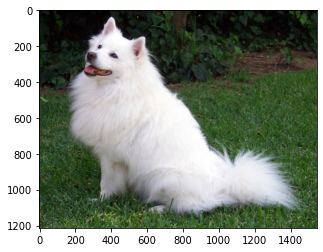

In [10]:
img = Image.open("dog.jpg")
plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


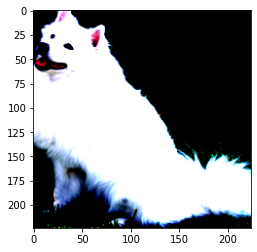

In [11]:
img = generate_preprocessing(val=True)(img)
img = img.unsqueeze(0)
print(img.shape)
plt.imshow(img[0].permute(1,2,0));

In [12]:
with torch.no_grad():
    output = model(img)[0].data.cpu()
    probabilities = F.softmax(output, dim=0)
probabilities.shape

torch.Size([1000])

In [13]:
sorted(zip(labels, probabilities), key=lambda x: -x[1])[:10]

[('Samoyed, Samoyede', tensor(0.8303)),
 ('Pomeranian', tensor(0.0699)),
 ('keeshond', tensor(0.0130)),
 ('collie', tensor(0.0108)),
 ('Great Pyrenees', tensor(0.0099)),
 ('Shetland sheepdog, Shetland sheep dog, Shetland', tensor(0.0081)),
 ('Eskimo dog, husky', tensor(0.0077)),
 ('Border collie', tensor(0.0067)),
 ('Siberian husky', tensor(0.0051)),
 ('Arctic fox, white fox, Alopex lagopus', tensor(0.0050))]

(48, 48)


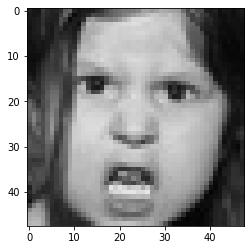

In [14]:
img = Image.open('images/train/angry/10002.jpg').convert("RGB")
print(img.size)
plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


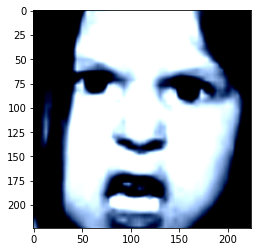

In [15]:
img = generate_preprocessing(val=True)(img)
img = img.unsqueeze(0)
print(img.shape)
plt.imshow(img[0].permute(1,2,0));

In [16]:
with torch.no_grad():
    output = model(img)[0].data.cpu()
    probabilities = F.softmax(output, dim=0)
sorted(zip(labels, probabilities), key=lambda x: -x[1])[:10]

[('neck brace', tensor(0.3038)),
 ("academic gown, academic robe, judge's robe", tensor(0.0796)),
 ('Windsor tie', tensor(0.0702)),
 ('prison, prison house', tensor(0.0636)),
 ('pickelhaube', tensor(0.0455)),
 ('abaya', tensor(0.0454)),
 ('sweatshirt', tensor(0.0321)),
 ('Band Aid', tensor(0.0262)),
 ('oboe, hautboy, hautbois', tensor(0.0210)),
 ('cloak', tensor(0.0189))]

In [17]:
train_dataset = ImageFolder('images/train', transform=generate_preprocessing(val=False))
val_dataset = ImageFolder('images/validation', transform=generate_preprocessing(val=True))

In [18]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [20]:
iter_train_dataloader = iter(train_dataloader)
train_batch = next(iter_train_dataloader)
train_batch[0].shape, train_batch[1].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fear


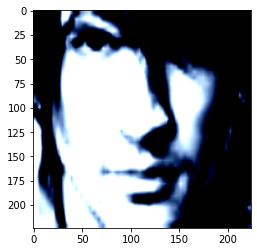

In [21]:
index = 2
print(train_dataset.classes[index])
plt.imshow(train_batch[0][index].permute(1,2,0));

In [22]:
device = torch.cuda.is_available() and torch.device(0) or torch.device('cpu')
device

device(type='cpu')

In [23]:
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False), nn.Linear(in_features=1280, out_features=7, bias=True))
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
writer = SummaryWriter('runs/facial_expressions_v1')

best_accuracy = 0.0
for epoch in range(num_epochs):
    print(f'Epoch #{epoch+1}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_accuracy = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                
                accuracy = torch.sum(preds == labels) / len(inputs)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy 
            
            if phase == 'train' and i % 10 == 9:
                writer.add_scalar(f'train loss',
                                  running_loss / 10,
                                  epoch * len(dataloaders['train']) + i)
                writer.add_scalar(f'train accuracy',
                                  running_accuracy / 10,
                                  epoch * len(dataloaders['train']) + i)
                running_loss = 0.0
                running_accuracy = 0.0
        
        if phase == 'val':
            writer.add_scalar(f'val loss',
                              running_loss / len(dataloaders['val']),
                              epoch)
            writer.add_scalar(f'val loss',
                              running_accuracy / len(dataloaders['val']),
                              epoch)
            if running_accuracy > best_accuracy:
                best_accuracy = running_accuracy
                torch.save(model.state_dict(), 'best_checkpoint.pkl')

Epoch #1


  1%|          | 15/1802 [00:17<33:33,  1.13s/it] 

In [23]:
model.load_state_dict(torch.load('best_checkpoint.pkl'))

<All keys matched successfully>

In [81]:
model.eval();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


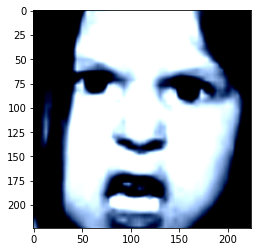

In [83]:
plt.imshow(img[0].cpu().permute(1,2,0));

In [89]:
img = img.to(device)
with torch.no_grad():
    logits = model(img)
    probabilities = F.softmax(logits, dim=1)[0]
sorted(zip(train_dataset.classes, probabilities), key=lambda x: -x[1])[:10]

[('angry', tensor(0.6121)),
 ('fear', tensor(0.1325)),
 ('neutral', tensor(0.1182)),
 ('sad', tensor(0.0821)),
 ('disgust', tensor(0.0334)),
 ('surprise', tensor(0.0174)),
 ('happy', tensor(0.0042))]